In [1]:
import StringIO

import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import scatter_matrix

import numpy as np

import matplotlib.pyplot as plt

import google.datalab.bigquery as bq

import tensorflow as tf

In [2]:
nikkei = bq.Query.from_table(bq.Table('bingo-ml-1.market_data.nikkei'), fields=['Date', 'Close']).execute().result().to_dataframe().set_index('Date')
ftse = bq.Query.from_table(bq.Table('bingo-ml-1.market_data.ftse'), fields=['Date', 'Close']).execute().result().to_dataframe().set_index('Date')

In [40]:
closing_data = pd.DataFrame()

closing_data['nikkei_close'] = nikkei['Close']
closing_data['ftse_close'] = ftse['Close']


In [70]:
closing_data['nikkei_close'][1]

10306.830078000001

In [6]:
closing_data.describe()

,nikkei_close,ftse_close
count,1426.000000,1416.000000
mean,12555.662053,6101.031214
std,3656.852037,555.791179
min,8160.009766,4805.799805
25%,9465.320069,5681.249878
50%,10811.660156,6009.399902
75%,15209.164795,6623.650146
max,20868.029297,7104.000000


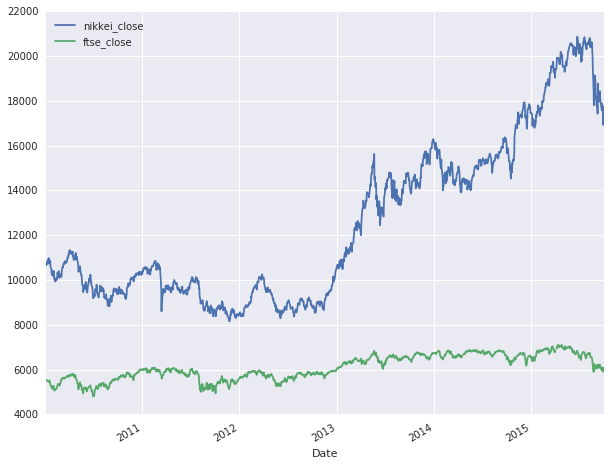

In [27]:
_ = pd.concat([closing_data['nikkei_close'],closing_data['ftse_close']],axis = 1).plot(figsize=(10,8))

In [12]:
closing_data['nikkei_close_scaled'] = closing_data['nikkei_close'] / max(closing_data['nikkei_close'])
closing_data['ftse_close_scaled'] = closing_data['ftse_close'] / max(closing_data['ftse_close'])

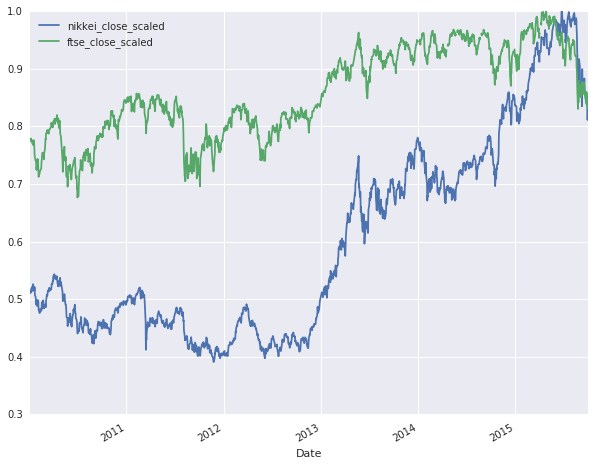

In [26]:
_ = pd.concat([closing_data['nikkei_close_scaled'],  closing_data['ftse_close_scaled']], axis=1).plot(figsize=(10,8))

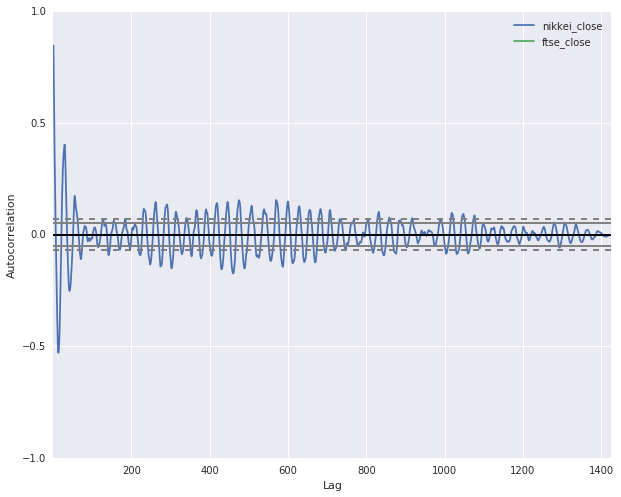

In [25]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(8)


_ = autocorrelation_plot(closing_data['nikkei_close'], label='nikkei_close')
_ = autocorrelation_plot(closing_data['ftse_close'], label='ftse_close')


_ = plt.legend(loc='upper right')

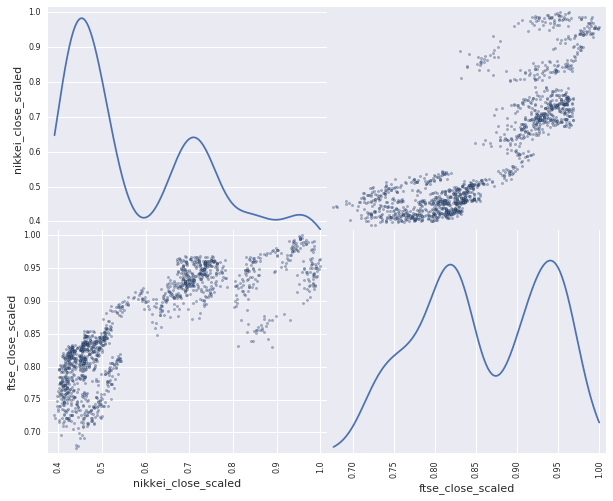

In [24]:
_ = scatter_matrix(pd.concat([closing_data['nikkei_close_scaled'],  closing_data['ftse_close_scaled']], axis=1), figsize=(10, 8), diagonal='kde')

In [18]:
log_return_data = pd.DataFrame()

log_return_data['nikkei_log_return'] = np.log(closing_data['nikkei_close']/closing_data['nikkei_close'].shift())
log_return_data['ftse_log_return'] = np.log(closing_data['ftse_close']/closing_data['ftse_close'].shift())


log_return_data.describe()

,nikkei_log_return,ftse_log_return
count,1425.000000,1405.000000
mean,0.000438,0.000269
std,0.145974,0.061087
min,-0.765156,-0.313256
25%,-0.034889,-0.021902
50%,0.010865,0.005344
75%,0.063169,0.033059
max,0.480498,0.176213


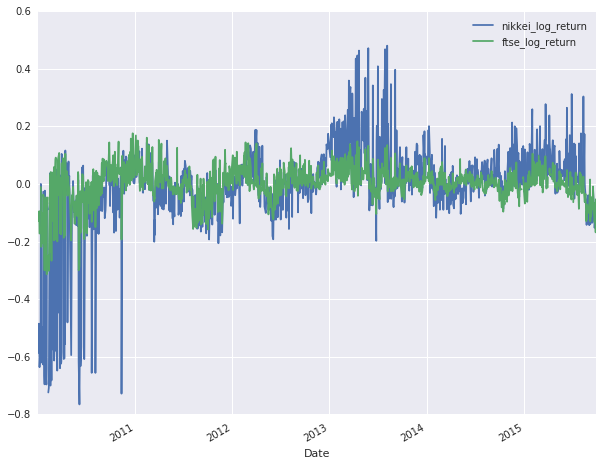

In [23]:
_ = pd.concat([log_return_data['nikkei_log_return'],  log_return_data['ftse_log_return']], axis=1).plot(figsize=(10, 8))

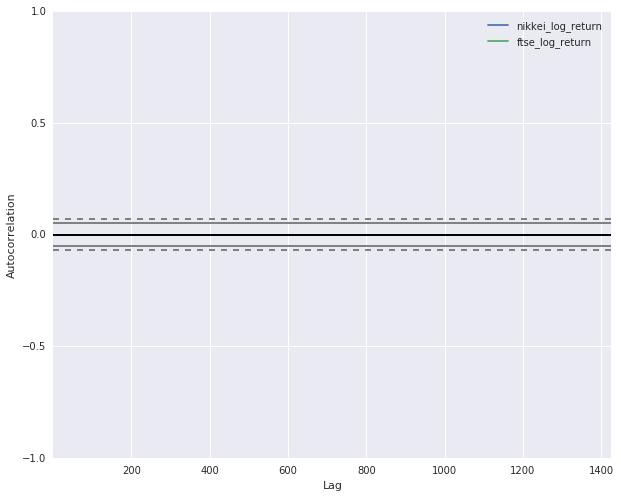

In [22]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(8)


_ = autocorrelation_plot(log_return_data['nikkei_log_return'], label='nikkei_log_return')
_ = autocorrelation_plot(log_return_data['ftse_log_return'], label='ftse_log_return')

_ = plt.legend(loc='upper right')

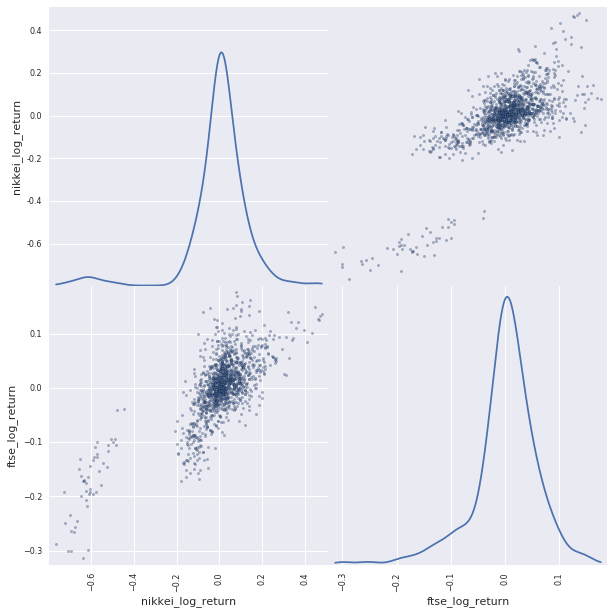

In [21]:
_ = scatter_matrix(log_return_data, figsize=(10, 10), diagonal='kde')

Seem to be pretty uncorrelated, which is good

In [30]:
tmp = pd.DataFrame()
tmp['nikkei_0'] = log_return_data['nikkei_log_return']
tmp['ftse_0'] = log_return_data['ftse_log_return']
tmp.corr().iloc[:,1]

nikkei_0    0.747854
ftse_0      1.000000
Name: ftse_0, dtype: float64

In [32]:
tmp = pd.DataFrame()
tmp['nikkei_0'] = log_return_data['nikkei_log_return'].shift(2)
tmp['ftse_0'] = log_return_data['ftse_log_return'].shift(3)
tmp.corr().iloc[:,0]

nikkei_0    1.000000
ftse_0      0.148035
Name: nikkei_0, dtype: float64

In [126]:
# Portfolio definition

len_series = len(nikkei)

def price_vector(time_lag, t):
  return closing_data[t-time_lag:t]

def current_price_nikkei(t):
  return closing_data['nikkei_close'][t]

def current_price_ftse(t):
  return closing_data['ftse_close'][t]

def portfolio_value(portfolio_shares, t):
  prices = [current_price_nikkei(t), current_price_ftse(t)]
  return np.inner(portfolio_shares,prices);

def alpha_fun(shares,t):
  alpha = shares[0]*current_price_nikkei(t)/portfolio_value(shares,t)
  return alpha


In [154]:
shares[0][0]

156.50065153519841

In [158]:
# Initialization

initial_endowment = 10e5

# initialize portfolio so to have 80% of capital invested, and alpha = 0.5
invest = 0.8;
invest_cash = invest*initial_endowment
fraction_nikkei = current_price_ftse(0)/current_price_nikkei(0)
ftse_0 = invest_cash/(fraction_nikkei*current_price_ftse(0))
nikkei_0 = ftse_0*fraction_nikkei

# initialize the price vector (prices)
price_0 = price_vector(1,1)
prices = [];
prices.append(price_0)
# initialize the b vector (shares)
shares_0=[nikkei_0,ftse_0]
shares = []
shares.append(shares_0)

# initialize the value vector (value)
value_0 = portfolio_value(shares,0)
value = []
value.append(value_0)

# initialize the alpha vector (alpha_vec)
alpha_0 = alpha_fun(shares_0,0)
alpha_vec = []
alpha_vec.append(alpha_0);

# initialize the cash vector (cash)
cash_0 = initial_endowment - invest_cash
cash = []
cash.append(cash_0)

# initialize the state vector (state)

state = pd.DataFrame()

state['price_nikkei'] = np.zeros(len_series)
state['price_ftse'] = np.zeros(len_series)
state['value'] = np.zeros(len_series)
state['alpha'] = np.zeros(len_series)
state['cash'] = np.zeros(len_series)

state['price_nikkei'][0] = current_price_nikkei(0)
state['price_ftse'][0] = current_price_ftse(0)
state['value'][0] = value_0
state['alpha'][0] = alpha_0
state['cash'][0] = cash_0


state

,price_nikkei,price_ftse,value,alpha,cash
0,9932.900391,5111.799805,3.109011e+06,0.5,200000.0
1,0.000000,0.000000,0.000000e+00,0.0,0.0
2,0.000000,0.000000,0.000000e+00,0.0,0.0
3,0.000000,0.000000,0.000000e+00,0.0,0.0
4,0.000000,0.000000,0.000000e+00,0.0,0.0
5,0.000000,0.000000,0.000000e+00,0.0,0.0
6,0.000000,0.000000,0.000000e+00,0.0,0.0
7,0.000000,0.000000,0.000000e+00,0.0,0.0
8,0.000000,0.000000,0.000000e+00,0.0,0.0
9,0.000000,0.000000,0.000000e+00,0.0,0.0
